# Understanding FFT Parameters: A Complete Visual Guide

## Introduction

This notebook explains **all the fundamental parameters** used in audio signal processing:

- **Sampling Rate (sr)**
- **FFT Size (n_fft)**
- **Hop Length**
- **Frequency Bins (n_bins)**
- **Window Functions**
- **Spectrogram Matrix**

Everything is explained with **extensive visualizations** and **practical examples**.

---

## Why These Parameters Matter

Understanding these parameters is **essential** for:
- Analyzing audio signals
- Building spectrograms
- Creating filter banks
- Deep learning with audio
- Speech and music processing

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


---

# 1. Sampling Rate (sr)

## What is it?

The **sampling rate** is the number of samples taken per second from a continuous signal.

- **Units**: Hertz (Hz) or samples/second
- **Common values**: 8000, 16000, 22050, 44100, 48000 Hz

## Analogy

Think of it like **camera frame rate** for audio:
- Video: 30 frames/second captures motion
- Audio: 44100 samples/second captures sound

## The Nyquist Theorem

**Key Rule**: To capture a frequency, sample at **at least twice that frequency**.

$$\text{Maximum Frequency} = \frac{\text{Sampling Rate}}{2}$$

This is the **Nyquist frequency**.

**Examples:**
- sr = 44100 Hz → Max = 22050 Hz
- sr = 16000 Hz → Max = 8000 Hz
- sr = 8000 Hz → Max = 4000 Hz

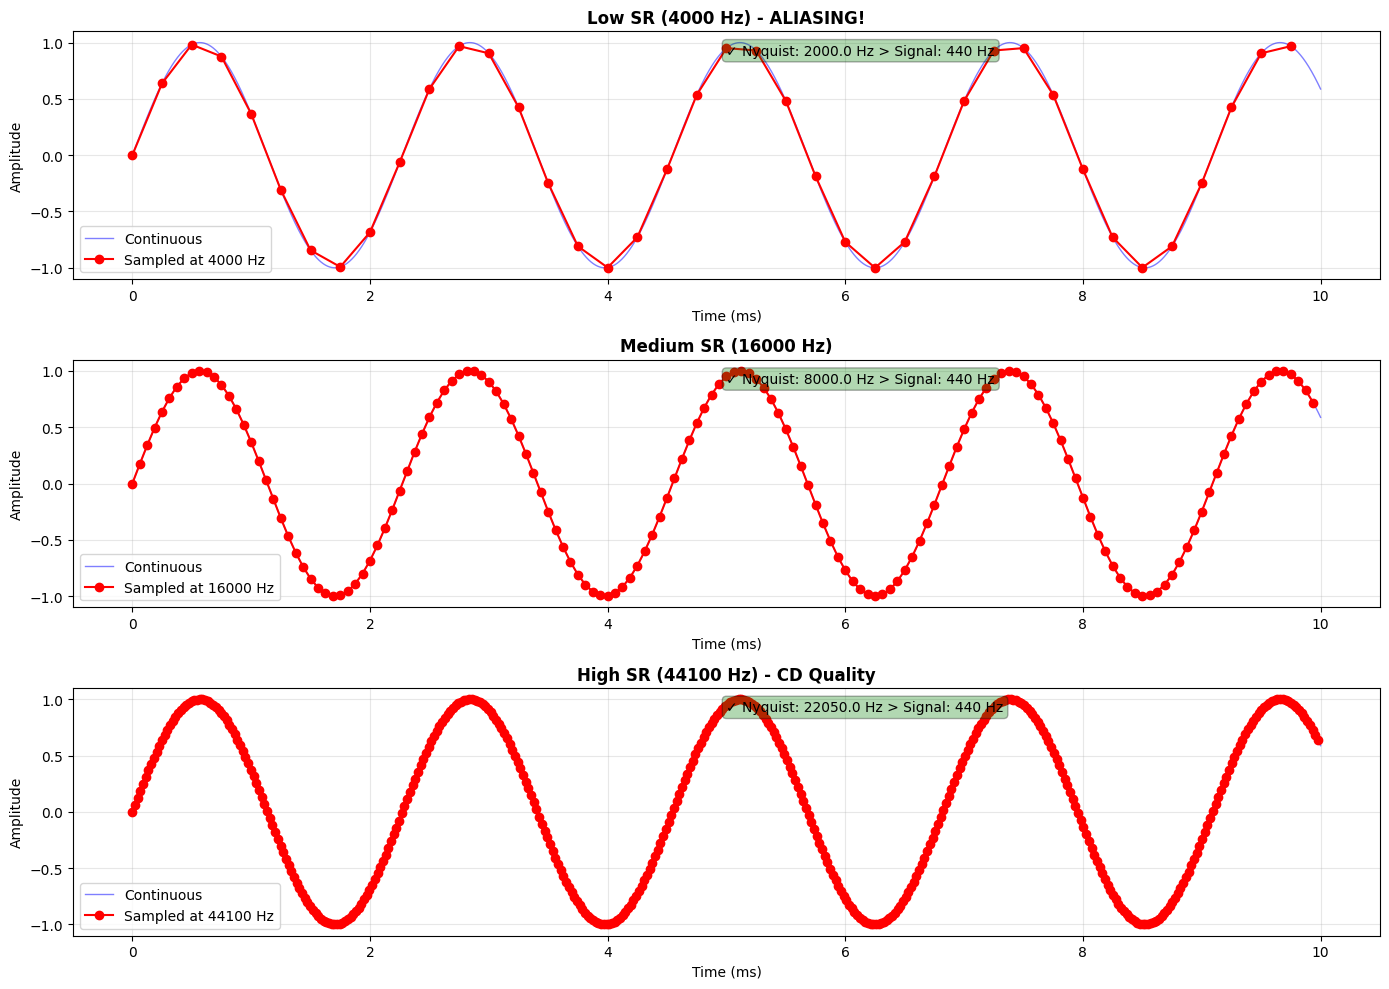

Key Observations:
  - Signal: 440 Hz
  - At 4000 Hz: Cannot capture properly (aliasing)
  - At 16000 Hz: Can capture
  - At 44100 Hz: High quality capture


In [3]:
# Visualize sampling rate
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

frequency = 440  # Hz (A note)
duration = 0.01  # 10 ms
t_continuous = np.linspace(0, duration, 10000)
signal_continuous = np.sin(2 * np.pi * frequency * t_continuous)

sampling_rates = [4000, 16000, 44100]
titles = ['Low SR (4000 Hz) - ALIASING!', 'Medium SR (16000 Hz)', 'High SR (44100 Hz) - CD Quality']

for idx, (sr, title) in enumerate(zip(sampling_rates, titles)):
    t_sampled = np.arange(0, duration, 1/sr)
    signal_sampled = np.sin(2 * np.pi * frequency * t_sampled)
    
    axes[idx].plot(t_continuous * 1000, signal_continuous, 'b-', linewidth=1, alpha=0.5, label='Continuous')
    axes[idx].plot(t_sampled * 1000, signal_sampled, 'ro-', markersize=6, linewidth=1.5, label=f'Sampled at {sr} Hz')
    axes[idx].set_xlabel('Time (ms)')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    nyquist = sr / 2
    if frequency > nyquist:
        axes[idx].text(0.5, 0.95, f'⚠️ Nyquist: {nyquist} Hz < Signal: {frequency} Hz',
                      transform=axes[idx].transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.3),
                      verticalalignment='top')
    else:
        axes[idx].text(0.5, 0.95, f'✓ Nyquist: {nyquist} Hz > Signal: {frequency} Hz',
                      transform=axes[idx].transAxes, bbox=dict(boxstyle='round', facecolor='green', alpha=0.3),
                      verticalalignment='top')

plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"  - Signal: {frequency} Hz")
print(f"  - At 4000 Hz: Cannot capture properly (aliasing)")
print(f"  - At 16000 Hz: Can capture")
print(f"  - At 44100 Hz: High quality capture")

### Common Sampling Rates

| SR (Hz) | Nyquist | Use Case |
|---------|---------|----------|
| 8000 | 4000 Hz | Telephone speech |
| 16000 | 8000 Hz | Voice assistants |
| 22050 | 11025 Hz | Low-quality music |
| 44100 | 22050 Hz | CD quality (standard) |
| 48000 | 24000 Hz | Professional audio |
| 96000 | 48000 Hz | High-res audio |

---

# 2. FFT Size (n_fft)

## What is it?

The **FFT size** is the number of samples used for each FFT calculation.

- **Must be power of 2**: 256, 512, 1024, 2048, 4096...
- **Common value**: 2048
- **Also called**: Window size, frame size

## What n_fft Determines

### 1. Frequency Resolution

$$\text{Freq Resolution} = \frac{\text{sr}}{\text{n\_fft}}$$

**Example** (sr = 44100 Hz):
- n_fft = 256 → 172 Hz (coarse)
- n_fft = 2048 → 21.5 Hz (fine)
- n_fft = 4096 → 10.8 Hz (very fine)

### 2. Number of Frequency Bins

$$\text{n\_bins} = \frac{\text{n\_fft}}{2} + 1$$

**Examples:**
- n_fft = 512 → 257 bins
- n_fft = 2048 → 1025 bins
- n_fft = 4096 → 2049 bins

**Why This Number?**
FFT produces symmetric output: The FFT of a real signal produces a symmetric spectrum
We only need half: Due to symmetry, we only keep the first half (positive frequencies)
Plus DC component: We add 1 for the DC component (0 Hz)

### 3. Time Window

$$\text{Time Window} = \frac{\text{n\_fft}}{\text{sr}}$$

**Example** (sr = 44100 Hz):
- n_fft = 256 → 5.8 ms
- n_fft = 2048 → 46.4 ms
- n_fft = 4096 → 92.9 ms

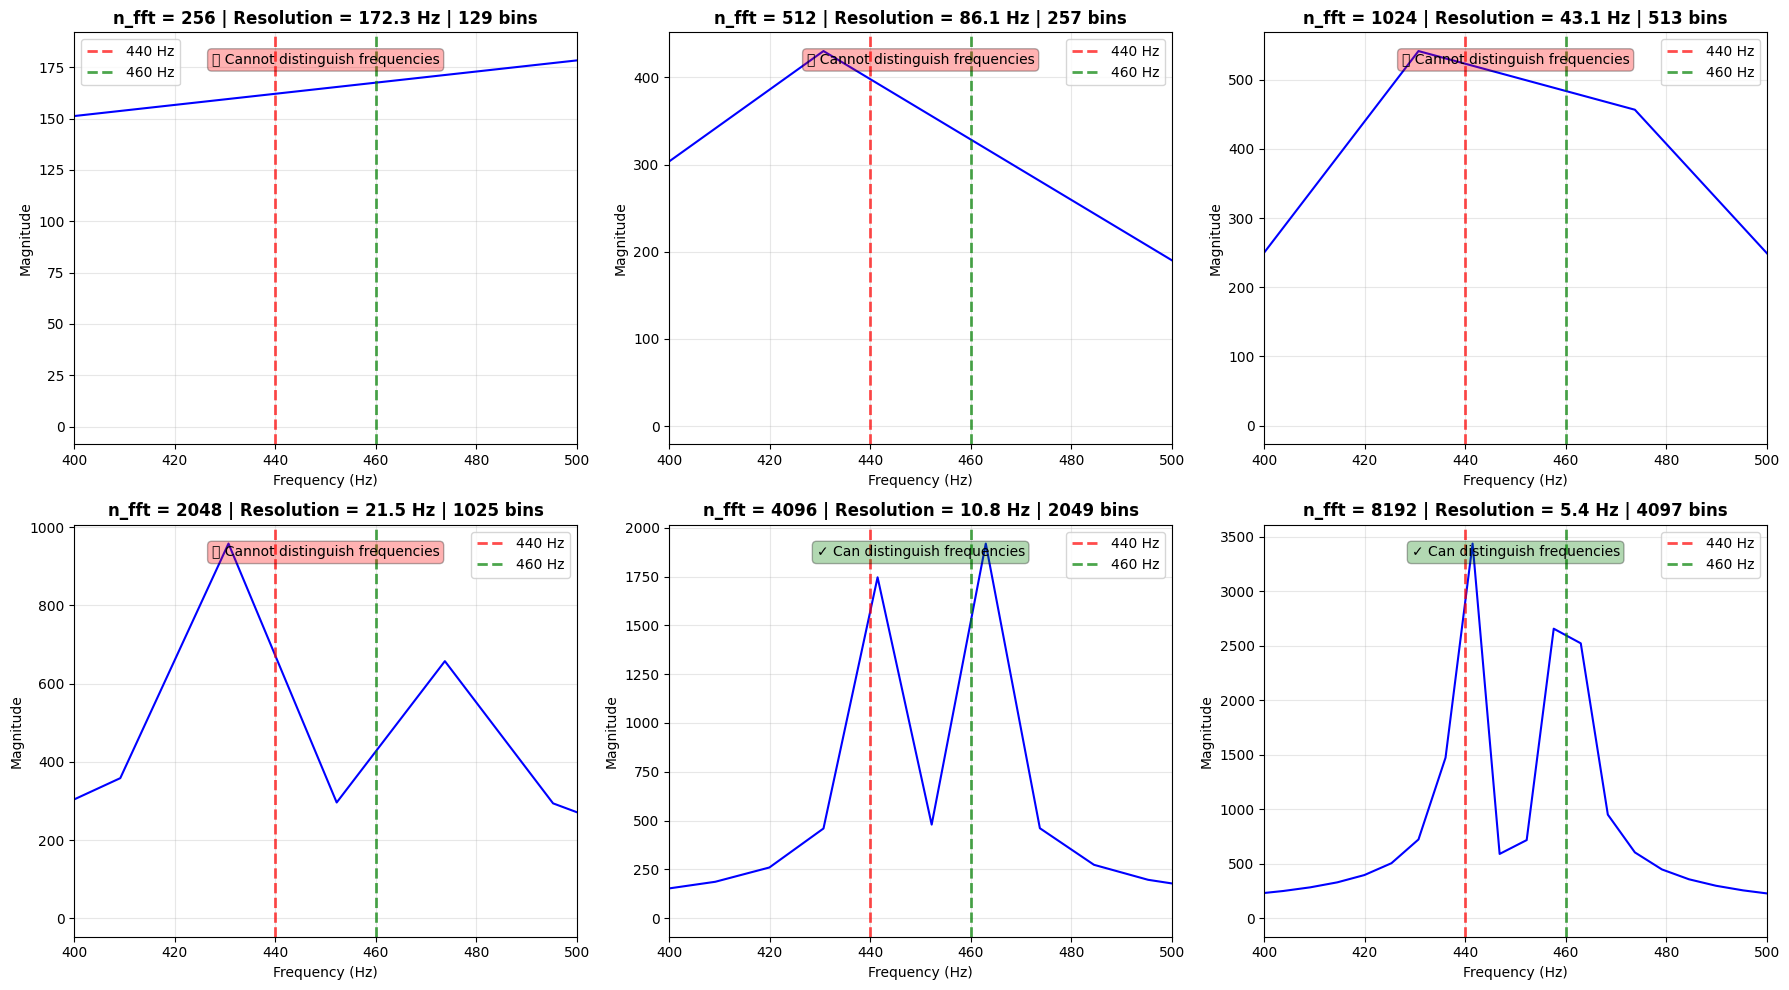

Key Observations:
  - Signal length: 8820 samples (0.2 seconds)
  - Two frequencies: 440 Hz and 460 Hz (20 Hz apart)
  - Larger n_fft = Better frequency resolution
  - n_fft = 2048, 4096, and 8192 can clearly distinguish the two peaks
  - n_fft = 8192 gives resolution of ~5.4 Hz - excellent separation!


In [7]:
# Demonstrate frequency resolution
sr = 44100
duration = 0.2  # Increased from 0.1 to 0.2 seconds
t = np.linspace(0, duration, int(sr * duration))

# Two close frequencies
freq1, freq2 = 440, 460  # 20 Hz apart
test_signal = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t)

n_fft_values = [256, 512, 1024, 2048, 4096, 8192]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, n_fft in enumerate(n_fft_values):
    # Only use n_fft if we have enough samples
    if n_fft > len(test_signal):
        print(f"Warning: n_fft={n_fft} is larger than signal length={len(test_signal)}")
    
    fft_result = np.fft.fft(test_signal[:n_fft]) #This takes the first n_fft samples from test_signal and computes the FFT.
                                            #k ranges from 0 to n_fft-1
                                            #for each k => X[k] = Σ(n=0 to N-1) x[n] · e^(-i·2π·k·n/N)
                                                #=> for each k - it'll will return a complex number which represents magnitude and phase if frequency bin k
    frequencies = np.fft.fftfreq(n_fft, 1/sr) #This creates an array of frequency values that correspond to each bin in your FFT result.
                                              #Without this, your FFT result is just an array of magnitudes with no frequency labels.
                                              #fftfreq tells you "this magnitude corresponds to 440 Hz"
                                              # or it'll return frequency value of kth bin
    magnitude = np.abs(fft_result)
    
    positive_idx = frequencies >= 0
    freq_res = sr / n_fft
    n_bins = n_fft // 2 + 1
    
    axes[idx].plot(frequencies[positive_idx], magnitude[positive_idx], 'b-', linewidth=1.5)
    axes[idx].set_xlim([400, 500])
    axes[idx].axvline(freq1, color='r', linestyle='--', linewidth=2, label=f'{freq1} Hz', alpha=0.7)
    axes[idx].axvline(freq2, color='g', linestyle='--', linewidth=2, label=f'{freq2} Hz', alpha=0.7)
    axes[idx].set_xlabel('Frequency (Hz)')
    axes[idx].set_ylabel('Magnitude')
    axes[idx].set_title(f'n_fft = {n_fft} | Resolution = {freq_res:.1f} Hz | {n_bins} bins', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

    freq_separation = abs(freq2 - freq1)  # 20 Hz

    if freq_res > freq_separation:
        axes[idx].text(0.5, 0.95, '❌ Cannot distinguish frequencies',
                      transform=axes[idx].transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.3),
                      ha='center', va='top')
    else:
        axes[idx].text(0.5, 0.95, '✓ Can distinguish frequencies',
                      transform=axes[idx].transAxes, bbox=dict(boxstyle='round', facecolor='green', alpha=0.3),
                      ha='center', va='top')

plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"  - Signal length: {len(test_signal)} samples ({duration} seconds)")
print("  - Two frequencies: 440 Hz and 460 Hz (20 Hz apart)")
print("  - Larger n_fft = Better frequency resolution")
print("  - n_fft = 2048, 4096, and 8192 can clearly distinguish the two peaks")
print("  - n_fft = 8192 gives resolution of ~5.4 Hz - excellent separation!")

### The Trade-off: Time vs Frequency Resolution

**You cannot have both perfect time AND frequency resolution!**

| n_fft | Freq Resolution | Time Resolution | Use Case |
|-------|----------------|-----------------|----------|
| Small (256) | ❌ Poor | ✅ Good | Transients, percussion |
| Medium (2048) | ✅ Good | ✅ Good | General purpose |
| Large (4096) | ✅ Excellent | ❌ Poor | Harmonic analysis |

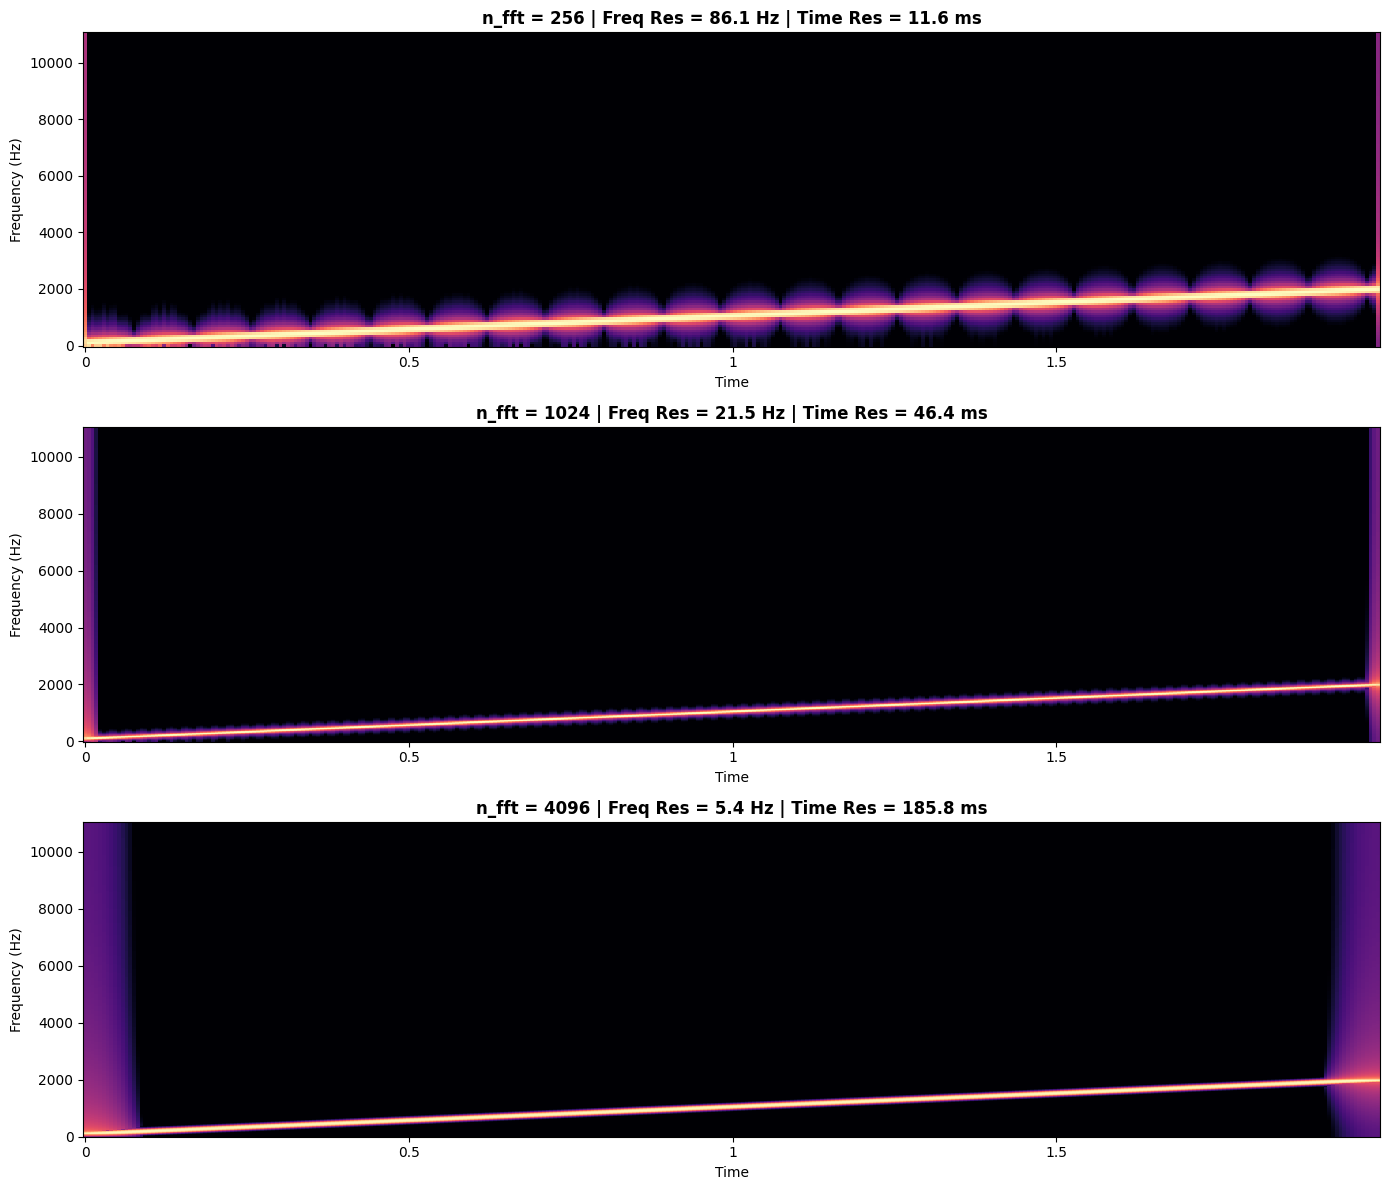

Observations:
  - Small n_fft: Sharp in time, blurry in frequency
  - Large n_fft: Sharp in frequency, blurry in time
  - Choose based on your analysis needs!


In [8]:
# Demonstrate time-frequency trade-off
sr = 22050
duration = 2.0
t = np.linspace(0, duration, int(sr * duration))

# Chirp: frequency sweeps from 100 to 2000 Hz
chirp_signal = signal.chirp(t, 100, duration, 2000, method='linear')

n_fft_values = [256, 1024, 4096]
hop_length = 128

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, n_fft in enumerate(n_fft_values):
    D = librosa.stft(chirp_signal, n_fft=n_fft, hop_length=hop_length)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='hz', cmap='magma', ax=axes[idx])
    
    freq_res = sr / n_fft
    time_res = n_fft / sr * 1000
    
    axes[idx].set_title(f'n_fft = {n_fft} | Freq Res = {freq_res:.1f} Hz | Time Res = {time_res:.1f} ms',
                       fontweight='bold')
    axes[idx].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

print("Observations:")
print("  - Small n_fft: Sharp in time, blurry in frequency")
print("  - Large n_fft: Sharp in frequency, blurry in time")
print("  - Choose based on your analysis needs!")

---

# 3. Hop Length

## What is it?

The **hop length** is the number of samples to advance between FFT windows.

- **Also called**: Hop size, stride
- **Common value**: n_fft / 4
- **Range**: n_fft/8 to n_fft/2

## Window Overlap

$$\text{Overlap \%} = \left(1 - \frac{\text{hop\_length}}{\text{n\_fft}}\right) \times 100$$

**Examples** (n_fft = 2048):
- hop = 2048 → 0% overlap
- hop = 1024 → 50% overlap
- hop = 512 → 75% overlap ✓ (standard)
- hop = 256 → 87.5% overlap

## What hop_length Determines

### Time Resolution

$$\text{Time Resolution} = \frac{\text{hop\_length}}{\text{sr}}$$

**Example** (sr = 44100 Hz):
- hop = 2048 → 46.4 ms
- hop = 512 → 11.6 ms (common)
- hop = 256 → 5.8 ms

### Number of Frames

$$\text{n\_frames} = \frac{\text{signal\_length} - \text{n\_fft}}{\text{hop\_length}} + 1$$

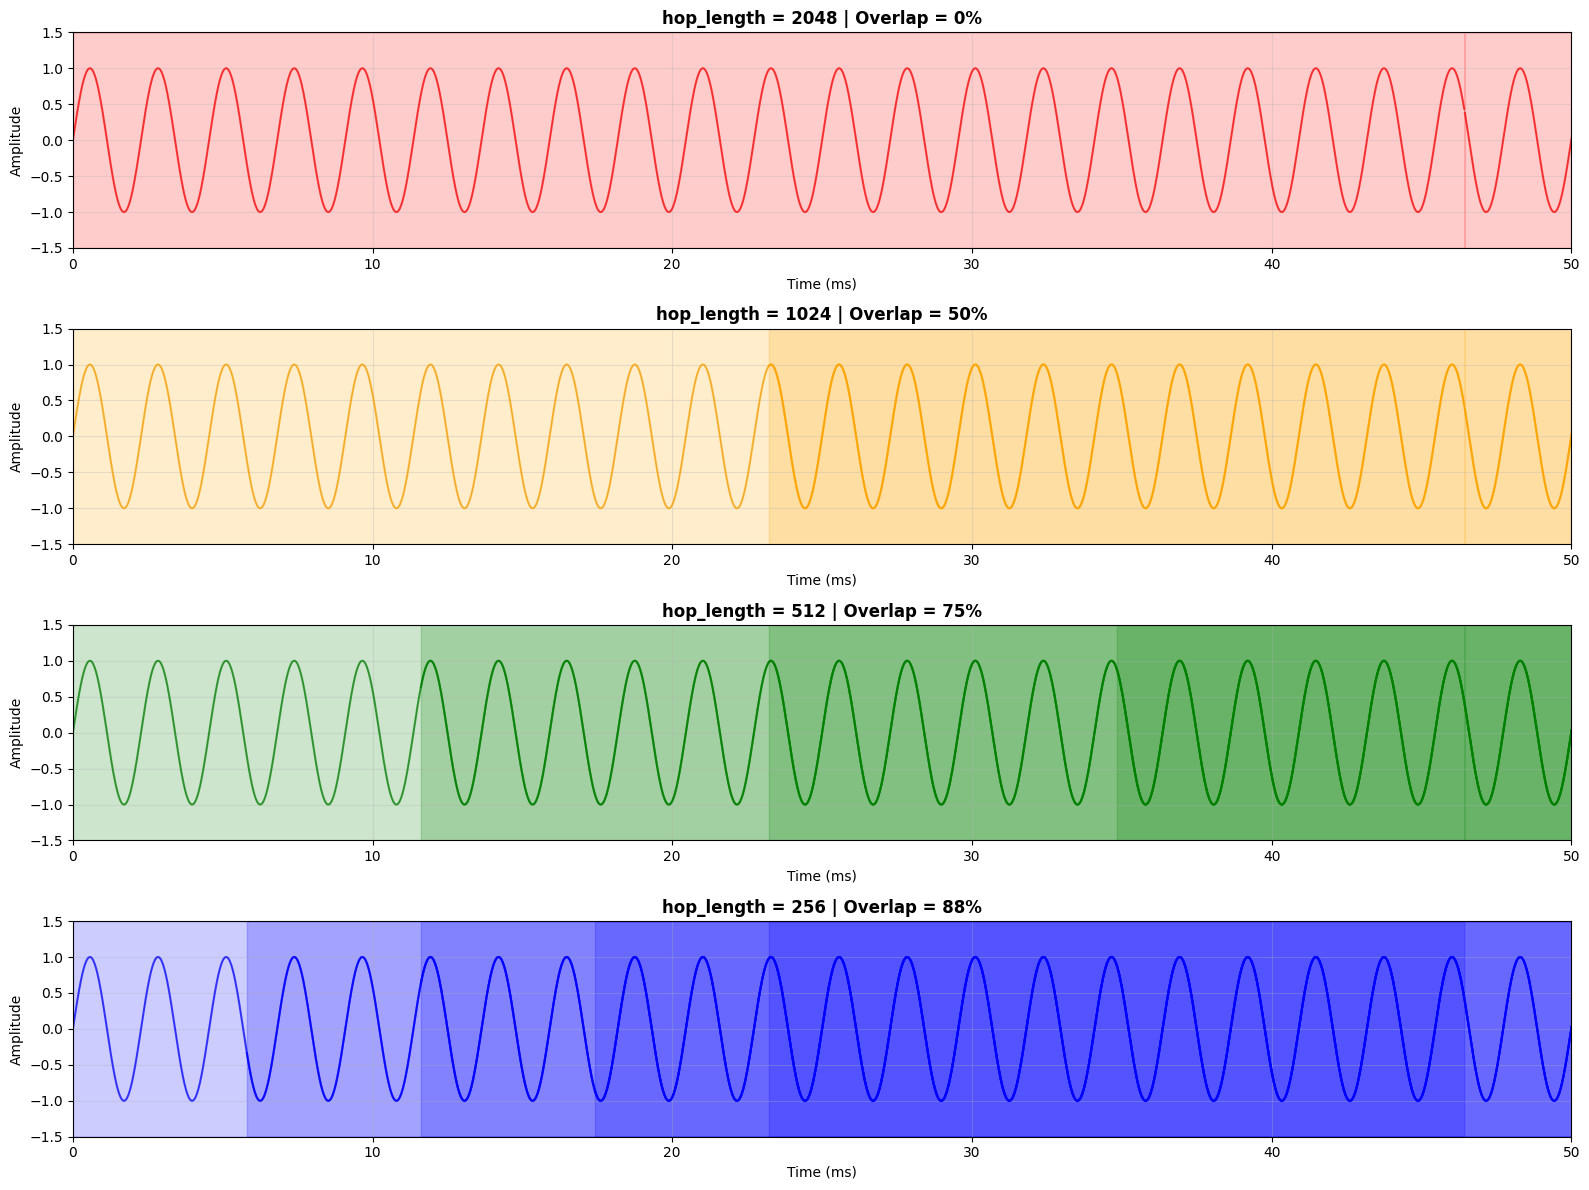

Key Observations:
  - Colored regions show FFT windows
  - More overlap = smoother spectrogram
  - 75% overlap (hop = n_fft/4) is standard


In [9]:
# Visualize hop length and overlap
sr = 44100
n_fft = 2048
duration = 0.1
t = np.linspace(0, duration, int(sr * duration))
test_signal = np.sin(2 * np.pi * 440 * t)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
hop_lengths = [2048, 1024, 512, 256]
colors = ['red', 'orange', 'green', 'blue']

for idx, (hop_length, color) in enumerate(zip(hop_lengths, colors)):
    overlap_pct = (1 - hop_length/n_fft) * 100
    
    axes[idx].plot(t * 1000, test_signal, 'k-', linewidth=0.5, alpha=0.3)
    
    window_starts = np.arange(0, len(test_signal) - n_fft, hop_length)
    for start in window_starts[:5]:
        window_time = t[start:start+n_fft] * 1000
        window_signal = test_signal[start:start+n_fft]
        axes[idx].fill_between(window_time, -1.5, 1.5, alpha=0.2, color=color)
        axes[idx].plot(window_time, window_signal, color=color, linewidth=1.5, alpha=0.7)
    
    axes[idx].set_xlim([0, 50])
    axes[idx].set_ylim([-1.5, 1.5])
    axes[idx].set_xlabel('Time (ms)')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(f'hop_length = {hop_length} | Overlap = {overlap_pct:.0f}%', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("  - Colored regions show FFT windows")
print("  - More overlap = smoother spectrogram")
print("  - 75% overlap (hop = n_fft/4) is standard")

### Choosing hop_length

| hop_length | Overlap | Recommendation |
|------------|---------|----------------|
| n_fft | 0% | ❌ Not recommended |
| n_fft/2 | 50% | ✅ Good |
| **n_fft/4** | **75%** | ✅ **Standard** |
| n_fft/8 | 87.5% | ✅ Very smooth |

**Rule of thumb**: Use hop_length = n_fft / 4

---

# 4. Frequency Bins

## What are they?

FFT output is divided into **frequency bins** - discrete containers for frequency ranges.

### Number of Bins

$$\text{n\_bins} = \frac{\text{n\_fft}}{2} + 1$$

### Center Frequency of Each Bin

$$\text{Frequency}[k] = k \times \frac{\text{sr}}{\text{n\_fft}}$$

**Example** (sr = 44100, n_fft = 2048):
- Bin 0: 0 Hz (DC)
- Bin 1: 21.5 Hz
- Bin 100: 2150 Hz
- Bin 1024: 22050 Hz (Nyquist)

### Bin Width

All bins have the **same width** = sr / n_fft

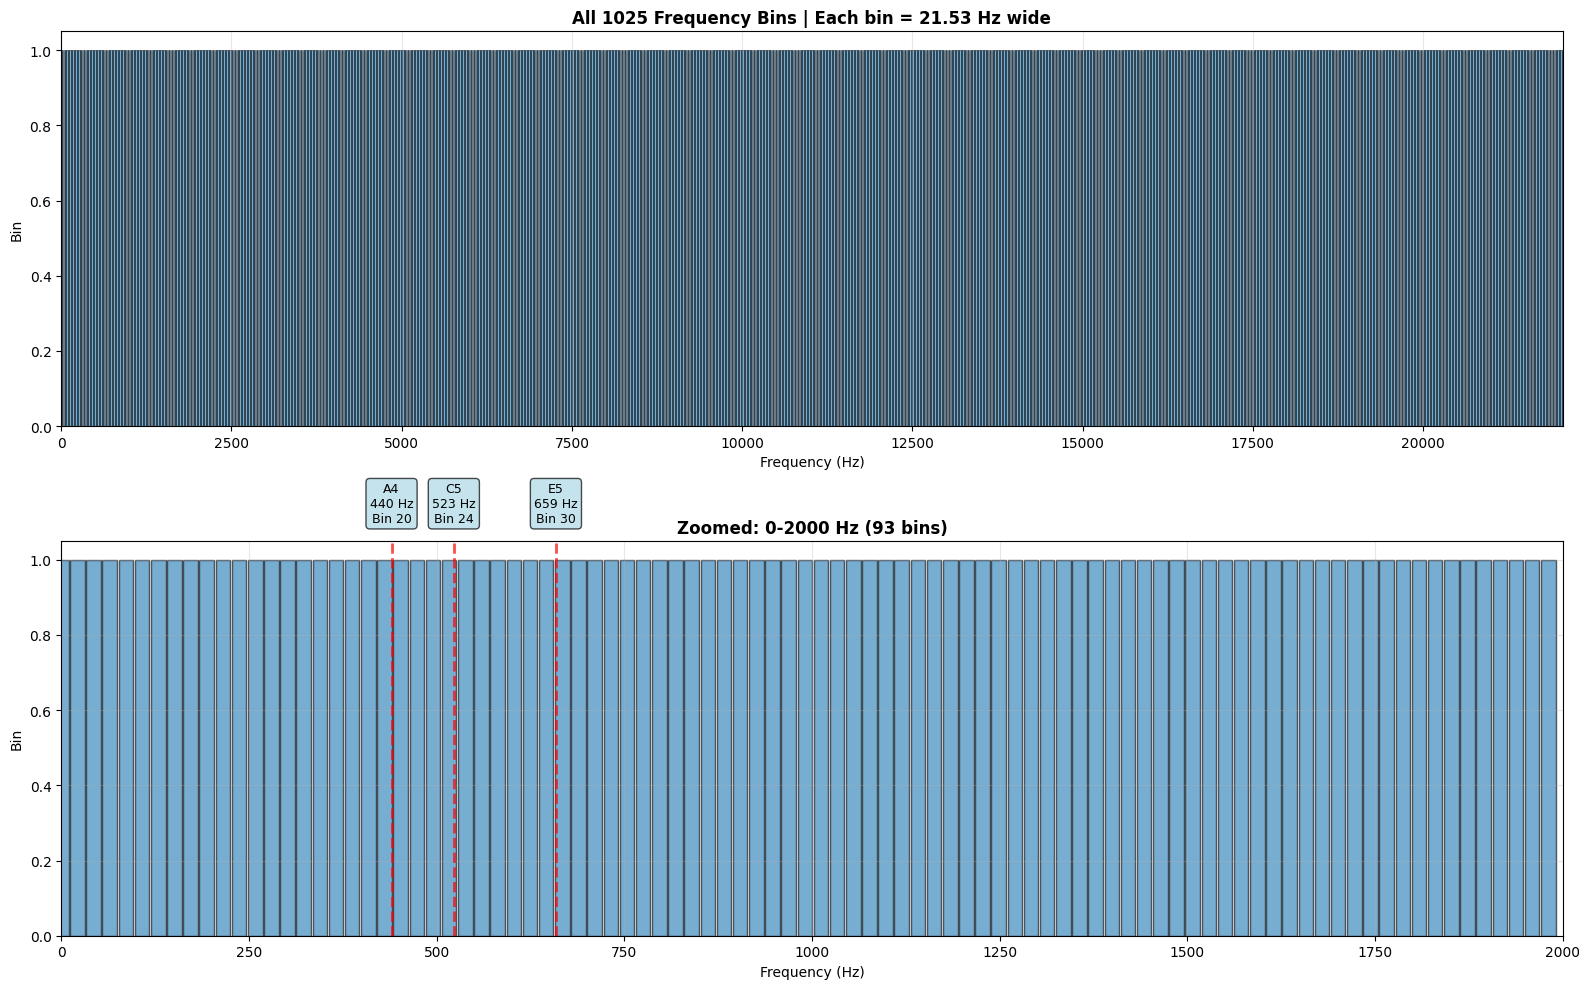

Frequency Bin Info:
  - Total bins: 1025
  - Bin width: 21.53 Hz
  - Range: 0 to 22050.0 Hz


In [ ]:
# Visualize frequency bins
sr = 44100
n_fft = 2048
n_bins = n_fft // 2 + 1
bin_width = sr / n_fft
bin_frequencies = np.arange(n_bins) * bin_width
                #np.arange(n_bins): Creates an array of bin indices: [0, 1, 2, 3, ..., n_bins-1]
                #bin_width: The frequency resolution (Hz per bin) = sr / n_fft
                #Multiplication: Each bin index is multiplied by the bin width to get its frequency
                #ex - sr = 44100, n_fft = 1024, bin_width = sr / n_fft  # = 43.1 Hz, n_bins = (n_fft/2)+1 = 513bins
                # Bin 0 → 0 Hz, Bin 1 → 43.1 Hz, Bin 2 → 86.2 Hz, Bin 10 → 431 Hz, Bin 512 → 22,050 Hz(nyquist freq)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# All bins
axes[0].bar(bin_frequencies, np.ones(n_bins), width=bin_width*0.9, 
           edgecolor='black', linewidth=0.5, alpha=0.6)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Bin')
axes[0].set_title(f'All {n_bins} Frequency Bins | Each bin = {bin_width:.2f} Hz wide', fontweight='bold')
axes[0].set_xlim([0, sr/2])
axes[0].grid(True, alpha=0.3, axis='x')

# Zoomed view
zoom_bins = bin_frequencies < 2000 #Creates a boolean mask (True/False array), 
                                   #True for bins below 2000 Hz, False for bins above
                                   #Example: [True, True, True, ..., False, False, False]
axes[1].bar(bin_frequencies[zoom_bins], np.ones(np.sum(zoom_bins)), 
           width=bin_width*0.9, edgecolor='black', linewidth=1, alpha=0.6)
           #bin_frequencies[zoom_bins] -> [0, 43.1, 86.2, ..., 1981.6] Hz (instead of going up to 22,050 Hz)
           #np.sum(zoom_bins) -> Counts how many True values (i.e., how many bins are below 2000 Hz), If bin_width = 43.1 Hz, then ~46 bins are below 2000 Hz
           #np.ones(np.sum(zoom_bins)) -> Heights for the bars (all uniform at height 1)

axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Bin')
axes[1].set_title(f'Zoomed: 0-2000 Hz ({np.sum(zoom_bins)} bins)', fontweight='bold')
axes[1].set_xlim([0, 2000])
axes[1].grid(True, alpha=0.3)

# Musical notes
notes = {'A4': 440, 'C5': 523, 'E5': 659} #Add vertical Line for these notes(corresponding freq bin)
for note, freq in notes.items():
    bin_num = int(freq / bin_width)
    axes[1].axvline(freq, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[1].text(freq, 1.1, f'{note}\n{freq} Hz\nBin {bin_num}',
                ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"Frequency Bin Info:")
print(f"  - Total bins: {n_bins}")
print(f"  - Bin width: {bin_width:.2f} Hz")
print(f"  - Range: 0 to {sr/2} Hz")

---

# 5. The Spectrogram Matrix

## What is it?

A **spectrogram** is a 2D matrix showing frequency content over time.

- **Rows**: Frequency bins
- **Columns**: Time frames
- **Values**: Energy/magnitude

### Shape

$$\text{Shape} = (\text{n\_bins}, \text{n\_frames})$$

**Example** (1 sec at 44100 Hz, n_fft=2048, hop=512):
- n_bins = 1025
- n_frames ≈ 83
- Shape: (1025, 83)

Spectrogram Matrix:
  - Shape: (1025, 87)
  - Frequency bins: 1025
  - Time frames: 87
  - Total elements: 89,175


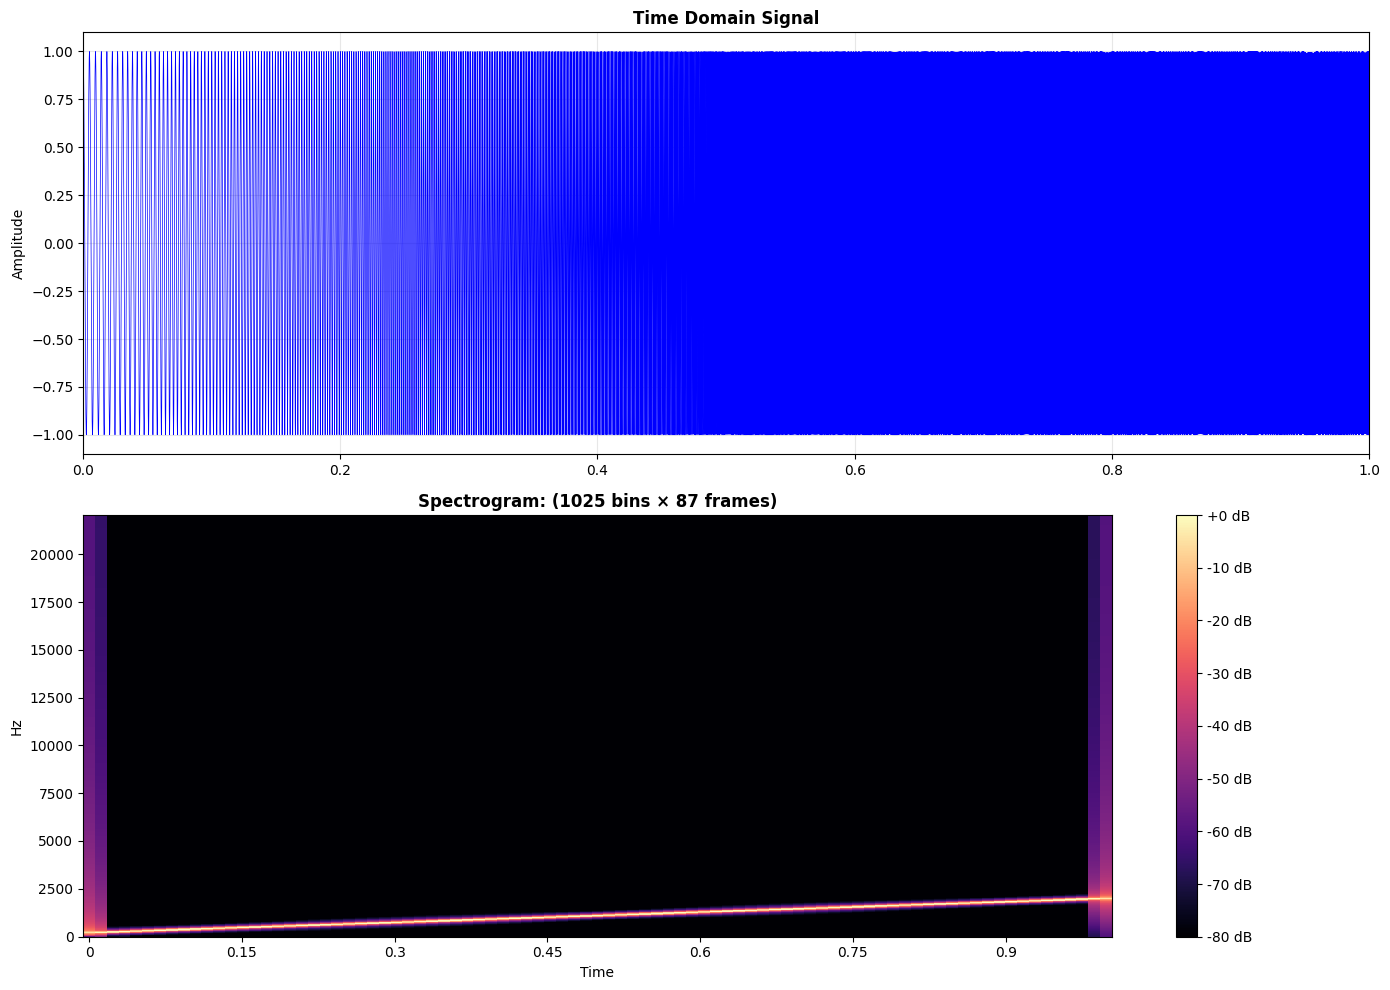

Understanding the Matrix:
  - Each column = frequency content at one time
  - Each row = one frequency across time
  - Bright = high energy


In [7]:
# Create and visualize spectrogram
sr = 44100
duration = 1.0
t = np.linspace(0, duration, int(sr * duration))
test_signal = signal.chirp(t, 200, duration, 2000, method='linear')

n_fft = 2048
hop_length = 512

D = librosa.stft(test_signal, n_fft=n_fft, hop_length=hop_length)
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

n_bins, n_frames = D.shape

print(f"Spectrogram Matrix:")
print(f"  - Shape: {D.shape}")
print(f"  - Frequency bins: {n_bins}")
print(f"  - Time frames: {n_frames}")
print(f"  - Total elements: {n_bins * n_frames:,}")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Waveform
axes[0].plot(t, test_signal, 'b-', linewidth=0.5)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time Domain Signal', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, duration])

# Spectrogram
librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz', cmap='magma', ax=axes[1])
axes[1].set_title(f'Spectrogram: ({n_bins} bins × {n_frames} frames)', fontweight='bold')
plt.colorbar(librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                                      x_axis='time', y_axis='hz', cmap='magma', ax=axes[1]),
            ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print("Understanding the Matrix:")
print("  - Each column = frequency content at one time")
print("  - Each row = one frequency across time")
print("  - Bright = high energy")

---

# 6. Parameter Summary & Calculator

## Quick Reference

| Parameter | Formula | What it controls |
|-----------|---------|------------------|
| **sr** | Given | Max frequency = sr/2 |
| **n_fft** | Power of 2 | Frequency resolution |
| **hop_length** | Usually n_fft/4 | Time resolution |
| **n_bins** | n_fft/2 + 1 | Number of frequencies |
| **n_frames** | (length-n_fft)/hop + 1 | Number of time steps |

In [8]:
# Parameter calculator
def calculate_parameters(sr, n_fft, hop_length, signal_duration):
    """Calculate all FFT parameters"""
    signal_length = int(sr * signal_duration)
    
    freq_resolution = sr / n_fft
    time_resolution = hop_length / sr
    n_bins = n_fft // 2 + 1
    n_frames = (signal_length - n_fft) // hop_length + 1
    overlap_pct = (1 - hop_length/n_fft) * 100
    nyquist = sr / 2
    
    print("="*60)
    print("FFT PARAMETER CALCULATOR")
    print("="*60)
    print(f"\nInput Parameters:")
    print(f"  - Sampling Rate: {sr} Hz")
    print(f"  - FFT Size: {n_fft}")
    print(f"  - Hop Length: {hop_length}")
    print(f"  - Signal Duration: {signal_duration} seconds")
    print(f"\nCalculated Values:")
    print(f"  - Nyquist Frequency: {nyquist} Hz")
    print(f"  - Frequency Resolution: {freq_resolution:.2f} Hz")
    print(f"  - Time Resolution: {time_resolution*1000:.2f} ms")
    print(f"  - Number of Bins: {n_bins}")
    print(f"  - Number of Frames: {n_frames}")
    print(f"  - Window Overlap: {overlap_pct:.1f}%")
    print(f"  - Spectrogram Shape: ({n_bins}, {n_frames})")
    print("="*60)

# Example calculations
calculate_parameters(sr=44100, n_fft=2048, hop_length=512, signal_duration=1.0)
print("\n")
calculate_parameters(sr=16000, n_fft=512, hop_length=160, signal_duration=1.0)

FFT PARAMETER CALCULATOR

Input Parameters:
  - Sampling Rate: 44100 Hz
  - FFT Size: 2048
  - Hop Length: 512
  - Signal Duration: 1.0 seconds

Calculated Values:
  - Nyquist Frequency: 22050.0 Hz
  - Frequency Resolution: 21.53 Hz
  - Time Resolution: 11.61 ms
  - Number of Bins: 1025
  - Number of Frames: 83
  - Window Overlap: 75.0%
  - Spectrogram Shape: (1025, 83)


FFT PARAMETER CALCULATOR

Input Parameters:
  - Sampling Rate: 16000 Hz
  - FFT Size: 512
  - Hop Length: 160
  - Signal Duration: 1.0 seconds

Calculated Values:
  - Nyquist Frequency: 8000.0 Hz
  - Frequency Resolution: 31.25 Hz
  - Time Resolution: 10.00 ms
  - Number of Bins: 257
  - Number of Frames: 97
  - Window Overlap: 68.8%
  - Spectrogram Shape: (257, 97)


---

# 7. Practical Guidelines

## Standard Configurations

### For Music (44.1 kHz)
```python
sr = 44100
n_fft = 2048
hop_length = 512  # 75% overlap
```

### For Speech (16 kHz)
```python
sr = 16000
n_fft = 512
hop_length = 160  # 68.75% overlap
```

### For Real-time (Low Latency)
```python
sr = 16000
n_fft = 256
hop_length = 128  # 50% overlap
```

## Decision Guide

**Need good frequency resolution?** → Increase n_fft

**Need good time resolution?** → Decrease hop_length

**Need smooth spectrogram?** → Decrease hop_length (more overlap)

**Need fast computation?** → Decrease n_fft, increase hop_length

---

# Summary

## Key Takeaways

1. **Sampling Rate (sr)**: Determines max frequency (Nyquist = sr/2)

2. **FFT Size (n_fft)**: Controls frequency resolution and number of bins
   - Larger = better frequency resolution, worse time resolution

3. **Hop Length**: Controls time resolution and overlap
   - Smaller = better time resolution, smoother spectrogram
   - Standard: n_fft/4 (75% overlap)

4. **Frequency Bins**: n_fft/2 + 1 discrete frequency containers

5. **Spectrogram**: 2D matrix (n_bins × n_frames)

## Remember

- **Time-Frequency Trade-off**: Cannot have perfect resolution in both
- **Standard values work well**: sr=44100, n_fft=2048, hop=512
- **Adjust based on needs**: Speech vs music vs real-time

---

**You now understand all the fundamental FFT parameters!** 🎉

These concepts are the foundation for:
- Filter banks
- Mel spectrograms
- Audio deep learning
- Speech and music processing